# 🚢 Titanic - Complete Solution

**Goal**: Predict survival on the Titanic (Binary Classification)

**Metric**: Accuracy

---

## 📦 Setup

In [1]:
import sys
sys.path.append('../../..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

# Our shared utilities
from shared.utils import set_seed
from shared.auto_eda import quick_eda

set_seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

%matplotlib inline

## 📂 Load Data

In [2]:
train = pd.read_csv('data/raw/train.csv')
test = pd.read_csv('data/raw/test.csv')

print(f"Train: {train.shape}")
print(f"Test: {test.shape}")

# Save test IDs for submission
test_ids = test['PassengerId']

Train: (891, 12)
Test: (418, 11)


In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## 🔍 Quick Automated EDA

In [5]:
# Run our automated EDA
report = quick_eda(train, target_col='Survived')

🔍 Running Automated EDA...
✅ EDA Complete!

📊 AUTOMATED EDA SUMMARY

📁 Dataset: 891 rows × 12 columns
💾 Memory: 0.28 MB
🔄 Duplicates: 0 (0.0%)

📋 Column Types:
   Numerical: 7
   Categorical: 5
   Datetime: 0

❓ Missing Values:
   Total: 866 cells
   Columns affected: 3

💡 RECOMMENDATIONS:
   ⚠️ Consider dropping columns with >50% missing: ['Cabin']
   💡 Impute missing values (median for numerical, mode for categorical)
   🆔 Column 'Name' looks like an ID - consider excluding from features
   📊 High cardinality in 'Ticket' (681 values) - consider encoding carefully
   📊 High cardinality in 'Cabin' (147 values) - consider encoding carefully
   📈 Outliers detected in 4 columns - consider clipping or transformation
   ↗️ Column 'SibSp' is highly skewed - consider log transformation
   ↗️ Column 'Parch' is highly skewed - consider log transformation
   ↗️ Column 'Fare' is highly skewed - consider log transformation



## 📊 Survival Analysis

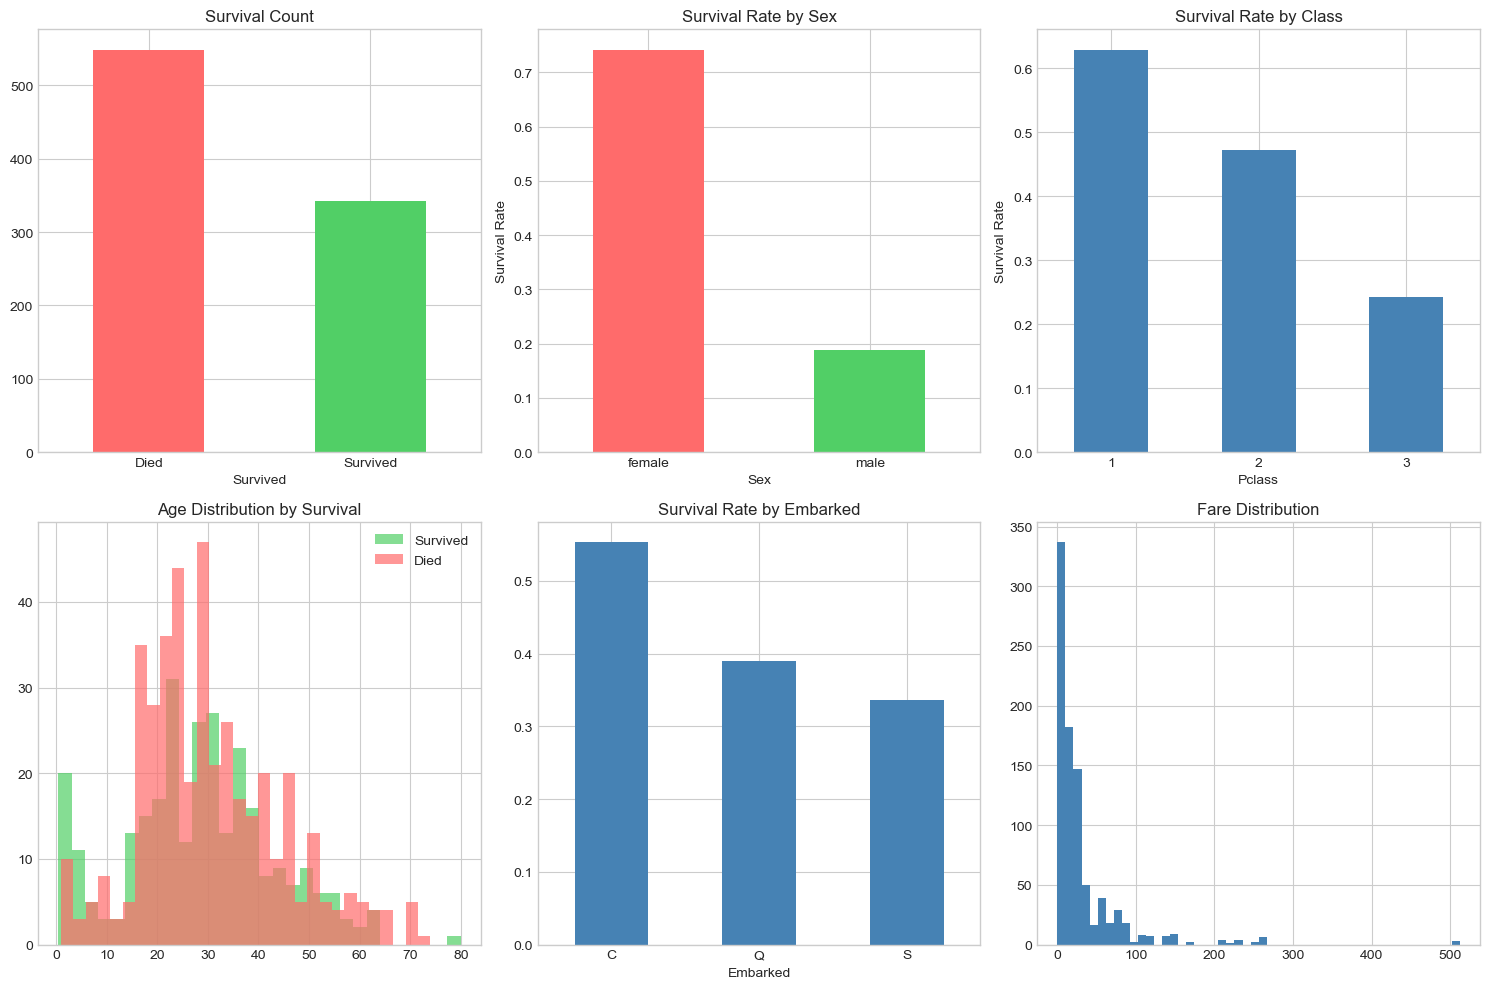

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Survival rate
train['Survived'].value_counts().plot(kind='bar', ax=axes[0,0], color=['#ff6b6b', '#51cf66'])
axes[0,0].set_title('Survival Count')
axes[0,0].set_xticklabels(['Died', 'Survived'], rotation=0)

# By Sex
train.groupby('Sex')['Survived'].mean().plot(kind='bar', ax=axes[0,1], color=['#ff6b6b', '#51cf66'])
axes[0,1].set_title('Survival Rate by Sex')
axes[0,1].set_ylabel('Survival Rate')
axes[0,1].tick_params(rotation=0)

# By Pclass
train.groupby('Pclass')['Survived'].mean().plot(kind='bar', ax=axes[0,2], color='steelblue')
axes[0,2].set_title('Survival Rate by Class')
axes[0,2].set_ylabel('Survival Rate')
axes[0,2].tick_params(rotation=0)

# Age distribution
train[train['Survived']==1]['Age'].hist(ax=axes[1,0], bins=30, alpha=0.7, label='Survived', color='#51cf66')
train[train['Survived']==0]['Age'].hist(ax=axes[1,0], bins=30, alpha=0.7, label='Died', color='#ff6b6b')
axes[1,0].set_title('Age Distribution by Survival')
axes[1,0].legend()

# By Embarked
train.groupby('Embarked')['Survived'].mean().plot(kind='bar', ax=axes[1,1], color='steelblue')
axes[1,1].set_title('Survival Rate by Embarked')
axes[1,1].tick_params(rotation=0)

# Fare distribution
train['Fare'].hist(ax=axes[1,2], bins=50, color='steelblue')
axes[1,2].set_title('Fare Distribution')

plt.tight_layout()
plt.show()

## 🧹 Feature Engineering

In [7]:
def engineer_features(df):
    """Feature engineering for Titanic dataset."""
    df = df.copy()
    
    # --- Extract Title from Name ---
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.')
    
    # Group rare titles
    title_mapping = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Rev': 'Rare', 'Dr': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Mme': 'Mrs', 'Ms': 'Miss', 'Lady': 'Rare',
        'Sir': 'Rare', 'Capt': 'Rare', 'Countess': 'Rare', 'Don': 'Rare',
        'Jonkheer': 'Rare', 'Dona': 'Rare'
    }
    df['Title'] = df['Title'].map(title_mapping).fillna('Rare')
    
    # --- Family Features ---
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # --- Age Groups ---
    # Fill missing ages with median by Title
    df['Age'] = df.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))
    df['Age'] = df['Age'].fillna(df['Age'].median())  # Fallback
    
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100], 
                            labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
    df['IsChild'] = (df['Age'] < 12).astype(int)
    
    # --- Fare ---
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['FarePerPerson'] = df['Fare'] / df['FamilySize']
    df['FareBin'] = pd.qcut(df['Fare'], 4, labels=['Low', 'Mid', 'High', 'VeryHigh'], duplicates='drop')
    
    # --- Cabin ---
    df['HasCabin'] = df['Cabin'].notna().astype(int)
    df['Deck'] = df['Cabin'].str[0].fillna('Unknown')
    
    # --- Embarked ---
    df['Embarked'] = df['Embarked'].fillna('S')  # Most common
    
    # --- Sex ---
    df['Sex'] = (df['Sex'] == 'male').astype(int)
    
    return df

In [8]:
# Apply feature engineering
train_fe = engineer_features(train)
test_fe = engineer_features(test)

print(f"Train shape after FE: {train_fe.shape}")
print(f"New features: {[c for c in train_fe.columns if c not in train.columns]}")

Train shape after FE: (891, 21)
New features: ['Title', 'FamilySize', 'IsAlone', 'AgeGroup', 'IsChild', 'FarePerPerson', 'FareBin', 'HasCabin', 'Deck']


## 🔧 Prepare Final Features

In [9]:
# Features to use
FEATURES = [
    'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
    'FamilySize', 'IsAlone', 'IsChild', 'HasCabin', 'FarePerPerson'
]

# Categorical features to encode
CAT_FEATURES = ['Title', 'Embarked', 'AgeGroup', 'FareBin', 'Deck']

# Encode categoricals
all_data = pd.concat([train_fe, test_fe], ignore_index=True)

for col in CAT_FEATURES:
    le = LabelEncoder()
    all_data[col] = le.fit_transform(all_data[col].astype(str))
    train_fe[col] = le.transform(train_fe[col].astype(str))
    test_fe[col] = le.transform(test_fe[col].astype(str))

ALL_FEATURES = FEATURES + CAT_FEATURES

X = train_fe[ALL_FEATURES]
y = train_fe['Survived']
X_test = test_fe[ALL_FEATURES]

print(f"Final features: {len(ALL_FEATURES)}")
print(f"X: {X.shape}, y: {y.shape}, X_test: {X_test.shape}")

Final features: 16
X: (891, 16), y: (891,), X_test: (418, 16)


## 🤖 Model Training

In [10]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=4, random_state=42)
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    results[name] = scores
    print(f"{name:25s} | CV Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

Logistic Regression       | CV Accuracy: 0.8058 (+/- 0.0224)
Random Forest             | CV Accuracy: 0.8328 (+/- 0.0166)
Gradient Boosting         | CV Accuracy: 0.8395 (+/- 0.0182)


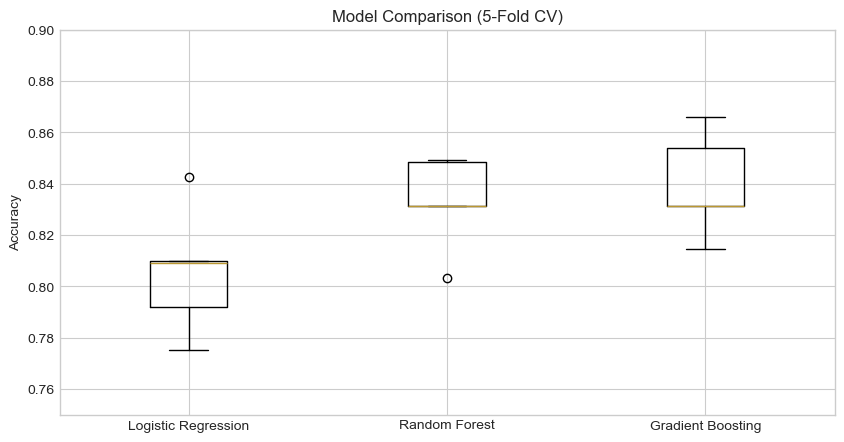

In [11]:
# Visualize results
plt.figure(figsize=(10, 5))
plt.boxplot(results.values(), labels=results.keys())
plt.title('Model Comparison (5-Fold CV)')
plt.ylabel('Accuracy')
plt.ylim(0.75, 0.90)
plt.show()

## 🎯 Train Final Model & Predict

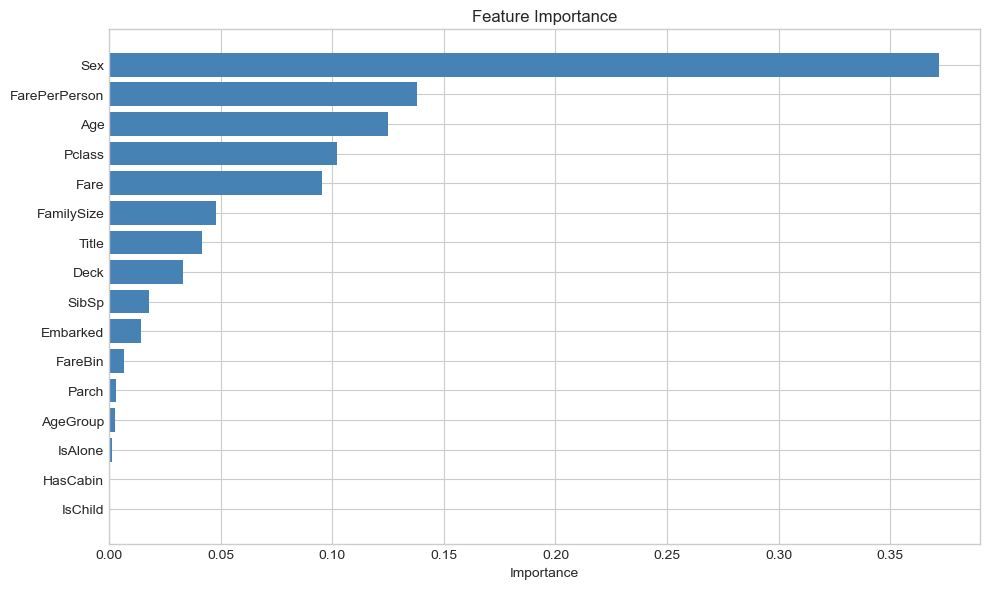

In [12]:
# Use best model (typically Random Forest or Gradient Boosting)
final_model = GradientBoostingClassifier(n_estimators=150, max_depth=4, random_state=42)
final_model.fit(X, y)

# Feature importance
importance = pd.DataFrame({
    'feature': ALL_FEATURES,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance['feature'], importance['importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [13]:
# Make predictions
predictions = final_model.predict(X_test)

print(f"Predictions shape: {predictions.shape}")
print(f"Survival rate: {predictions.mean():.2%}")

Predictions shape: (418,)
Survival rate: 36.84%


## 📤 Create Submission

In [14]:
# Create submission file
submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Survived': predictions
})

# Verify format
print(f"Submission shape: {submission.shape}")
print(f"Expected: (418, 2)")
print(f"\nColumns: {submission.columns.tolist()}")
submission.head(10)

Submission shape: (418, 2)
Expected: (418, 2)

Columns: ['PassengerId', 'Survived']


,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


In [15]:
# Save submission
import os
os.makedirs('submissions', exist_ok=True)

submission.to_csv('submissions/submission.csv', index=False)
print("✅ Submission saved to submissions/submission.csv")

# Quick sanity check
check = pd.read_csv('submissions/submission.csv')
print(f"\n📊 Sanity Check:")
print(f"   Rows: {len(check)} (expected 418)")
print(f"   Columns: {check.columns.tolist()}")
print(f"   Survived 0s: {(check['Survived']==0).sum()}")
print(f"   Survived 1s: {(check['Survived']==1).sum()}")

✅ Submission saved to submissions/submission.csv

📊 Sanity Check:
   Rows: 418 (expected 418)
   Columns: ['PassengerId', 'Survived']
   Survived 0s: 264
   Survived 1s: 154


---

## 🎉 Done!

Your submission file is ready at `submissions/submission.csv`.

**To submit:**
1. Go to [kaggle.com/c/titanic](https://www.kaggle.com/c/titanic)
2. Click "Submit Predictions"
3. Upload `submissions/submission.csv`

**Expected accuracy: ~78-80%** (Top 20% on leaderboard)

### 💡 Ideas to Improve
- Try ensemble of multiple models
- Add more feature engineering (ticket prefix, name length, etc.)
- Use LightGBM or XGBoost
- Tune hyperparameters with GridSearchCV